## Cálculo del rotacional del campo de velocidades en dos mallas distintas 

**Temas Selectos de Modelación Numérica** <br>
Facultad de Ciencias, UNAM <br>
Semestre 2021-2

En este notebook calcularemos el rotacioanl de un campo de velocidades de viento. Estos vientos son salidas de una configuración regional del modelo [WRF](https://www.mmm.ucar.edu/weather-research-and-forecasting-model).

Los objetivos de este notebook son:
1. Mostrarles las diferencias entre hacer cálculos con variables que comparten la misma malla y con variables en distintas mallas (malla escalonada o *staggered*). En particular trabajaremos con variables escalonadas horizontalmente en una malla Arakawa C. Esto les será útil porque las salidas de muchos modelos atmosféricos y oceánicos nos dan los campos de velocidades, temperatura, humedad, salinidad, etc, en mallas distintas.
2. Darles un ejemplo concreto del uso de archivos netcdf (extraccion de variables, operar con las variables, graficar los resultados).
3. Que aprendan dos de los cálculos más comunes y útiles que pueden hacer con campos de velocidades de viento: obtener el rotacional y la divergencia.

No olvides resolver los ejercicios de tarea al final del notebook. Entrega tu solución en un notebook en la carpeta de Classroom con el nombre `apellido_nombre_tarea05_sistemas_coordenadas.ipynb`.

In [1]:
# Importemos las bibliotecas de python
import matplotlib.pyplot as plt
import netCDF4
import numpy as np
%matplotlib inline
import cmocean as cmo

En en folder que descargaste hay un archivo llamado `wrf_2012_07_08_d1_small.nc` ($\approx$250 Mb). Este archivo netCDF contiene solo algunas de las variables que te dan las salidas del [modelo meteorológico operacional WRF](http://grupo-ioa.atmosfera.unam.mx/pronosticos/index.php/meteorologia) que corre diariamente el [grupo Interacción Océano-Atmosfera del CCA](http://grupo-ioa.atmosfera.unam.mx/). Como hicimos en el notebook 2 de Introducción a python, usaremos la función `Dataset` de la biblioteca netCDF4 para acceder a los datos.

In [2]:
filename = 'wrf_2012_07_08_d1_small.nc'
f = netCDF4.Dataset(filename)

Veamos que dimensiones tienen las variables en el archivo:   

In [3]:
f.dimensions

{'Time': <class 'netCDF4._netCDF4.Dimension'> (unlimited): name = 'Time', size = 26,
 'DateStrLen': <class 'netCDF4._netCDF4.Dimension'>: name = 'DateStrLen', size = 19,
 'bottom_top': <class 'netCDF4._netCDF4.Dimension'>: name = 'bottom_top', size = 27,
 'south_north': <class 'netCDF4._netCDF4.Dimension'>: name = 'south_north', size = 161,
 'west_east_stag': <class 'netCDF4._netCDF4.Dimension'>: name = 'west_east_stag', size = 245,
 'west_east': <class 'netCDF4._netCDF4.Dimension'>: name = 'west_east', size = 244,
 'south_north_stag': <class 'netCDF4._netCDF4.Dimension'>: name = 'south_north_stag', size = 162}

Del output anterior podemos ver que la malla tiene 244 puntos en la dirección este-oeste, 161 puntos en la dirección norte-sur, y que hay 26 records de tiempo. Adicionalmente hay dimensiones escalondadas o `staggered`(`_stag`) que corresponden a las mallas escalonadas de U y V y son más largas que la malla base por un punto.

Ahora veamos qué variables tenemos disponibles:

In [4]:
f.variables

{'Times': <class 'netCDF4._netCDF4.Variable'>
 |S1 Times(Time, DateStrLen)
 unlimited dimensions: Time
 current shape = (26, 19)
 filling on, default _FillValue of   used,
 'U': <class 'netCDF4._netCDF4.Variable'>
 float32 U(Time, bottom_top, south_north, west_east_stag)
     FieldType: 104
     MemoryOrder: XYZ
     description: x-wind component
     units: m s-1
     stagger: X
     coordinates: XLONG_U XLAT_U
 unlimited dimensions: Time
 current shape = (26, 27, 161, 245)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'U10': <class 'netCDF4._netCDF4.Variable'>
 float32 U10(Time, south_north, west_east)
     FieldType: 104
     MemoryOrder: XY 
     description: U at 10 M
     units: m s-1
     stagger: 
     coordinates: XLONG XLAT
 unlimited dimensions: Time
 current shape = (26, 161, 244)
 filling on, default _FillValue of 9.969209968386869e+36 used,
 'V': <class 'netCDF4._netCDF4.Variable'>
 float32 V(Time, bottom_top, south_north_stag, west_east)
     FieldType:

Las variables que nos interesan son las componentes de la velocidad del viento. El archivo nos proporciona dos velocidades: $U, V$ y $U10, V10$. 

Las componentes U y V corresponden al viento en 4 dimensiones: tiempo, $Z$, $Y$, $X$. Los metadatos de estas variables nos indican que $U$ está escalonada en la dirección $X$ con respecto a la malla base (centros) y $V$ en la dirección $Y$.

Las componentes U10 y V10 corresponden al viento a 10 m. Los metadatos nos indican que estas componentes tienen dimensiones tiempo, $Y$, $X$ y no están escalonadas, es decir, el modelo las calcula en la misma malla de centros.

### Paréntesis: ¿Por qué es útil calcular el rotacional del viento?

Recordemos que el rotacional de un campo vectorial de dos dimensiones $\vec{u}=(u,v)$ es un vector perpendicular a  $u$ y $v$ que está dado por
$$\nabla\times\vec{u}=\frac{\partial v}{\partial x}-\frac{\partial u}{\partial y}.$$
Si $u$ y $v$ son las componentes horizontales del vector velocidad del viento, el rotacional anterior apunta en dirección vertical hacia arriba cuando es positivo y hacia abajo cuando es negativo. Esta cantidad se conoce como *vorticidad* y nos permite saber, entre otras cosas, cuál es la dirección preferencial en la que una particula tendería a rotar en un punto del flujo; por ejemplo el "giro" de los vientos. En donde la vorticidad es positiva, se dice que la circualción es *ciclónica*. En el hemiferio norte esto significa que la circulación es en sentido contrario de las manecillas del reloj (como giran los huracanes que nos llegan del Atlántico). Cuando la vorticidad es negativa se dice que la circulación es *anticiclónica*. Las direcciones de giro son al revés en el hemisferio sur.

Calculemos el rotacional de los vientos en superficie. Estas variables se llaman U10 y V10 (vientos a 10 m) que es una medida estándar de vientos. Notemos que estas variables están ubicadas en los centros de las celdas de la malla, ambas en la misma malla.

In [5]:
tt = 10 # índice de tiempo. Solo vamos a leer 1 tiempo
T = f.variables['Times'] # Lee los tiempos de simulación
U10 = f.variables['U10'][tt,:,:] # Lee la variables U10 y V10 al tiempo tt
V10 = f.variables['V10'][tt,:,:]
spd10 = np.sqrt(U10**2+V10**2) # Calculemos la rapidez del viento para graficarla más tarde

# Para calcular el rotacional con esquema de diferencias centradas usamos
# las latitudes y longitudes correspondientes a cada componente de la
# velocidad U10, V10.
XLONG = f.variables['XLONG'][tt,:,:]
XLAT = f.variables['XLAT'][tt,:,:]

# XLON y XLAT están en grados asíq ue necesitamos e radio de la tierra 
# para convertir a longitudes de arco en metros 
R = 6371000 # radio de la Tierra en metros

nY, nX = np.shape(XLONG)
rotSup = np.zeros((nY, nX)) # vector en zeros para guardar el rotacional
divSup = np.zeros((nY, nX)) # vector en zeros para guradar la divergencia

In [6]:
for ii in range(1,nX-1):
    for jj in range(1,nY-1): 
        # Definimos a nuestros delta x y delta y por separado, 
        # recuerda que el orden de los índices es [iy,ix]
        deltX =  R*(XLONG[jj,ii+1]-XLONG[jj,ii-1])*(np.pi/180)*np.cos(np.deg2rad(XLAT[jj,ii]))
        deltY =  R*(XLAT[jj+1,ii]-XLAT[jj-1,ii])*(np.pi/180)

        rotSup[jj,ii] =  ((V10[jj,ii+1]-V10[jj,ii-1])/deltX-
                          (U10[jj,ii]-U10[jj-1,ii])/deltY)

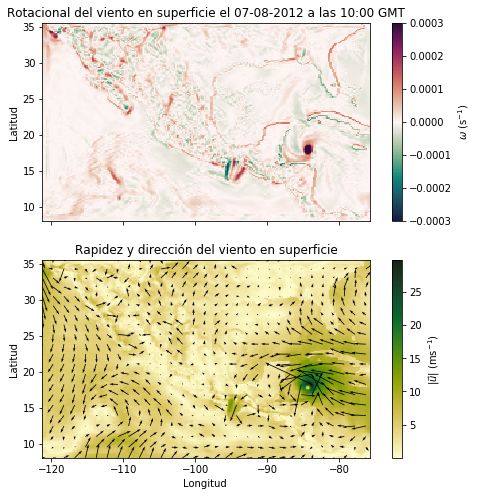

In [7]:
# Graficamos el rotacional al tiempo tt y la rapidez y dirección 
# del viento usando la función quiver.
anio = '%d%d%d%d' %(T[tt,0],T[tt,1],T[tt,2],T[tt,3])
mes = '%d%d' %(T[tt,5],T[tt,6])
dia = '%d%d' %(T[tt,8],T[tt,9])
hora = '%d%d' %(T[tt,11],T[tt,12])

sep = 8 # separación entre flechas del quiver

fig,(ax1,ax2)=plt.subplots(2,1,sharex=True, figsize=(8,8))

pc = ax1.pcolormesh(XLONG,XLAT,rotSup, cmap=cmo.cm.curl, vmin=-3E-4, vmax=3E-4)
cb = plt.colorbar(pc,ax=ax1,label=r'$\omega$ (s$^{-1}$)')

pc2 = ax2.pcolormesh(XLONG,XLAT,spd10, cmap=cmo.cm.speed)
cb2 = plt.colorbar(pc2,ax=ax2,label=r'|$\vec{u}$| (ms$^{-1}$)')
qv = ax2.quiver(XLONG[::sep,::sep],XLAT[::sep,::sep],U10[::sep,::sep],V10[::sep,::sep])

ax1.set_ylabel('Latitud')
ax2.set_ylabel('Latitud')
ax2.set_xlabel('Longitud ')
ax1.set_title('Rotacional del viento en superficie el %s-%s-%s a las %s:00 GMT' %(dia,mes,anio,hora))
ax2.set_title('Rapidez y dirección del viento en superficie')
ax1.set_aspect(1)
ax2.set_aspect(1)

plt.show()

Cómo adivinaste, el dominio del modelo abarca la república mexicana, una porción del Océano Pacífico, el Golfo de México y el Caribe. En estas figuras podemos ver dos zonas de alta vorticidad en el modelo. La mancha de alta vorticidad ciclónica del Caribe corresponde a una tormenta ciclónica, que se caracteriza por tener vientos intensos (colores verdes en la gráfica de rapidez) y vientos que giran en sentido de las manecillas del reloj (como las flechas indican). 

La segunda zona de vorticidad intensa corresponde a las manchas sobre el Istmo de Tehuantepec, en donde vemos que la alta/baja vorticidad está relacionada con los intensos vientos conocidos como "Tehuanos" que se forman en la región debido a un "gap" o espacio vacío entre la orografía. En este caso la vorticidad no está tan relacionada al giro como a la cizalla horizontal (variación horizontal del viento).

### Rotacional para mallas escalonadas

Ahora veamos cómo se calcula el rotacional cuando las variables $U$ y $V$ NO están en la misma malla. De nuevo usaremos el esquema de diferencias centradas pero ahora debemos tener cuidado de utilizar las latitudes y longitudes correpondientes a cada malla. En la figura siguiente puedes ver ilustrado el cálculo. La vorticidad queda calulada en el punto verde debido a que usamos medio paso de malla.

En la figura pueden ver que las componentes de la velocidad horizontal $u$ y $v$ están definidas en distintos puntos de la malla. En este caso, la malla del WRF es de tipo Arakawa C. 

![malla](esquema_malla.png)

Para este ejemplo usaremos las velocidades en el segundo nivel del modelo que está mucho más alto que la superfice (varios kilómetros).

Antes de calcular la vorticidad, hagámos un pequeño paréntesis para considerar cómo debemos calcular la rapidez del viento y cuál es la manera correcta de graficar los vectores de velocidad. Para calcular la rapidez del viento debemos saber los valores de $u$ y $v$ en el mismo punto, por lo que debemos interpolarlas a una misma malla. Por lo general lo hacemos a la malla de la presión y los trazadores (centros, rombos negros en la figura).

Una forma sencilla de hacer esto es calcular el valor promedio entre puntos de $u$ en la dirección $x$ y el valor promedio entre puntos de $v$ en la dirección $y$. Hagamos una función `interpola_centro` que tome como entradas los arreglos $u$ y $v$ y nos regrese valores interpolados a la malla de los centros: 

In [8]:
def interpola_centros(u,v):
    '''u y v son arreglos de numpy al menos dos dimensiones.'''
    u_interp = (u[...,:,1:]+u[...,:,:-1])/2
    v_interp = (v[...,1:,:]+v[...,:-1,:])/2
    return(u_interp,v_interp)

In [9]:
U2 = f.variables['U'][tt,2,:,:] # Lee el nivel 2 de la variables U y V al tiempo tt
V2 = f.variables['V'][tt,2,:,:]

# Caso especial para calular la rapidez (unstagger)
Uinter,Vinter = interpola_centros(np.squeeze(U2),np.squeeze(V2))
spd2 = np.sqrt(Uinter**2+Vinter**2) 

# Para calcular el rotacional con esquema de diferencias centradas usamos
# las latitudes y longitudes correspondientes a cada componente de la
# velocidad U2, V2.
XLONG_U = f.variables['XLONG_U'][tt,:,:]
XLAT_U = f.variables['XLAT_U'][tt,:,:]
XLONG_V = f.variables['XLONG_V'][tt,:,:]
XLAT_V = f.variables['XLAT_V'][tt,:,:]

Veamos como diferen las tres mallas (para U, para V y la de los trazadores en los centros de las celdas):

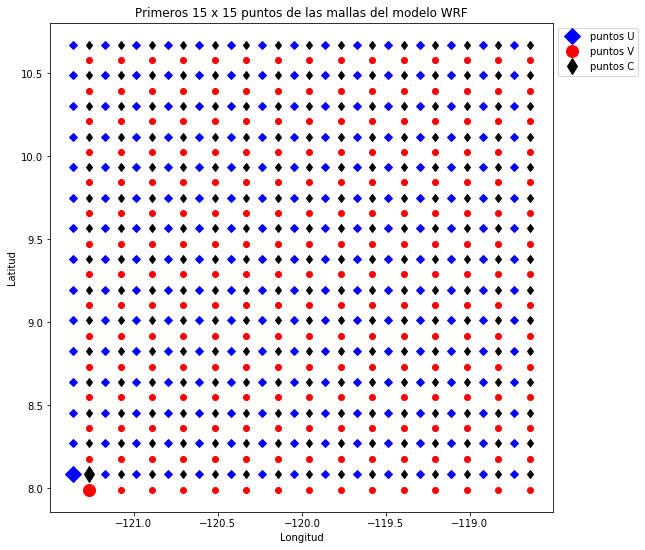

In [10]:
npts = 15

fig,ax = plt.subplots(1,1, figsize=(9,9))
ax.plot(XLONG_U[:npts,:npts],XLAT_U[:npts,:npts],'bD')
ax.plot(XLONG_V[:npts,:npts],XLAT_V[:npts,:npts],'ro')
ax.plot(XLONG[:npts,:npts],XLAT[:npts,:npts],'kd')

ax.plot(XLONG_U[0,0],XLAT_U[0,0],'bD', markersize=12,label='puntos U')
ax.plot(XLONG_V[0,0],XLAT_V[0,0],'ro', markersize=12,label='puntos V')
ax.plot(XLONG[0,0],XLAT[0,0],'kd', markersize=12,label='puntos C')

ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
ax.legend(bbox_to_anchor=(1,1))
ax.set_title('Primeros %d x %d puntos de las mallas del modelo WRF' % (npts,npts))
plt.show()

In [11]:
nY, nX = np.shape(XLONG)
rot2 = np.zeros((nY, nX)) # vector en zeros para guardar el rotacional

In [12]:
for ii in range(1,nX-1):
    for jj in range(1,nY-1): 
        # Definimos a nuestros delta x y delta y por separado, 
        # recuerda que el orden de los índices es [iy,ix]
        deltX2 = R*(XLONG_V[jj,ii+1]-XLONG_V[jj,ii-1])*(np.pi/180)*np.cos(np.deg2rad(XLAT[jj,ii]))
        deltY2 = R*(XLAT_U[jj+1,ii]-XLAT_U[jj-1,ii])*(np.pi/180)

        rot2[jj,ii] = ((V2[jj,ii+1]-V2[jj,ii])/deltX2-
                       (U2[jj+1,ii+1]-U2[jj,ii+1])/deltY2)

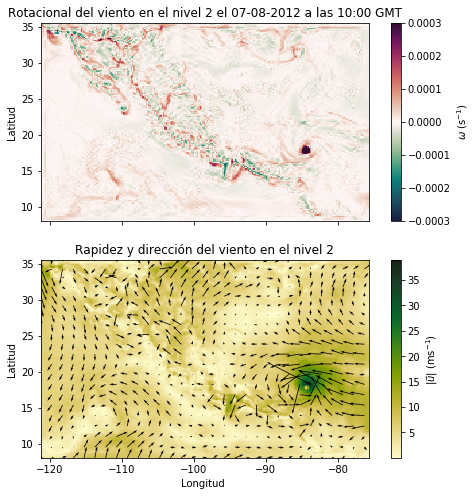

In [13]:
# Graficamos el rotacional al tiempo tt para U2 y V2 y 
# la rapidez y dirección del viento usando la función quiver.
sep=8

fig,(ax1,ax2)=plt.subplots(2,1,sharex=True, figsize=(8,8))

pc = ax1.pcolormesh(XLONG,XLAT,rot2, cmap=cmo.cm.curl, vmin=-3E-4, vmax=3E-4)
cb = plt.colorbar(pc,ax=ax1,label=r'$\omega$ (s$^{-1}$)')

pc2 = ax2.pcolormesh(XLONG,XLAT,spd2, cmap=cmo.cm.speed)
cb2 = plt.colorbar(pc2,ax=ax2,label=r'|$\vec{u}$| (ms$^{-1}$)')
qv = ax2.quiver(XLONG[::sep,::sep],XLAT[::sep,::sep],Uinter[::sep,::sep],Vinter[::sep,::sep])

ax1.set_ylabel('Latitud')
ax2.set_ylabel('Latitud')
ax2.set_xlabel('Longitud ')
ax1.set_title('Rotacional del viento en el nivel 2 el %s-%s-%s a las %s:00 GMT' %(dia,mes,anio,hora))
ax2.set_title('Rapidez y dirección del viento en el nivel 2')
ax1.set_aspect(1)
ax2.set_aspect(1)

plt.show()

### Ejercicios de tarea
 
1. Haz un código para calcular la divergencia del campo de velocidades en superficie (U10, V10) y en el segundo nivel (U2,V2). 
2. Grafica la divergencia que obtuviste para ambas velocidades usando la función `pcolormesh`. Recuerda que las gráficas deben tener nombres de los ejes, barra de color, unidades, etc.
3. Extra: A partir de los puntos 1 y 2 haz una animación de la evolución de la divergencia en el tiempo (o de la velocidad, o del rotacional, lo que prefieras). Revisa el notebook del ejemplo de una solución numérica para generar la animación. 
4. Agrega en el notebook de tarea las respuestas a los ejercicios que se hayan dejado en la clase teórica.